In [14]:
#Imports
import numpy as np
import sympy as sym
import h5py as h5
from matplotlib import pyplot as plt
from scipy.integrate import quad
from scipy.integrate import dblquad
from scipy.integrate import nquad
import scipy.optimize as so
import scipy.special as ss
from scipy.special import ellipe
from scipy.special import ellipk

#Settings
options={'limit':100} #Set maximum number of subdivisions to 100 instead of 50.

In [15]:
#Constants
Mbh = 2.7e9                                                 #mass of the central black hole in (solar mass)
G = 4.300e-6                                                #gravitational constant (kpc/solar mass*(km/s)^2)
h = 8.9                                                     #radial scale-length (kpc)
rho00 = 0.31e9                                              #prefactor that will cancel
epsdisk = 5.0                                               #from Noordermeer's paper
absmag = -22.02                                             #absolute magnitude 
magsun = 4.42                                               #absolute magnitude of the sun
z0 = 0.2*h                                                  #half-thickness (kpc)
R = 4*h                                                     #cut-off radius (kpc)
d = 0.2*h                                                   #cut-off length upper limits (kpc)
L0 = np.power(10, (0.4*(magsun-absmag)))                    #Absolute Magnitude to luminosity
n = 2.7                                                     #concentration parameter that describes the curvature of the profile in a radius-magnitude plot, n=4 is de Vaucoileurs profile
re = 2.6                                                    #1kpc
ups = 2.8                                                   #mass-to-light ratio (from Rotation Curves of Sersic Bulges paper)
q = 0.33                                                    #intrinsic axis ratio
i = 45*(np.pi/180)                                          #inclination angle
L = 3.27e10                                                 #luminosity
rc = 1.4                                                    #core radius (kpc)

In [16]:
#Variables
xd = np.linspace(1, 10, 100)                        #x from/to and line smoothness
r0 = np.linspace(0.1, 10, 20)                       #radius over which plotting will be done

In [60]:
#Run necessary code using existing imports and variables

%run -i Scripts/bulge.py                    #Time: Roughly 2 minutes if building, Almost 0 if not.
%run -i Scripts/disk.py                     #Time: 40 Minutes if building, Almost 0 if not.
%run -i Scripts/halo.py                     #Time: Almost 0
%run -i Scripts/blackhole.py                #Time: Almost 0

Scripts/disk.py:53: RuntimeWarning: overflow encountered in cosh
  drho_rz = lambda r,z: durho0(r, R, h, d)*(np.power(np.cosh(z/z0), -2))
Scripts/disk.py:55: RuntimeWarning: invalid value encountered in double_scalars
  f = lambda z,r,u: u*drho_rz(u, z)*(2*K(r,u,z))/(np.pi*np.sqrt(r*u*px(r,u,z)))                                   #Inner Function (3D)
Scripts/disk.py:56: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  intf = lambda u,r: quad(f, 0, np.inf, args=(r,u,))[0]                                                           #Integrate Function


In [61]:
#Define remaining necessary functions.
vtotal = lambda r: np.sqrt(vcdm(r)**2+vd(r)**2+vbh(r)**2+vb(r)**2)
vtotalv = np.vectorize(vtotal)

Scripts/blackhole.py:53: RuntimeWarning: overflow encountered in cosh
Scripts/blackhole.py:55: RuntimeWarning: invalid value encountered in double_scalars
Scripts/blackhole.py:56: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.


TypeError: 'Dataset' object is not callable

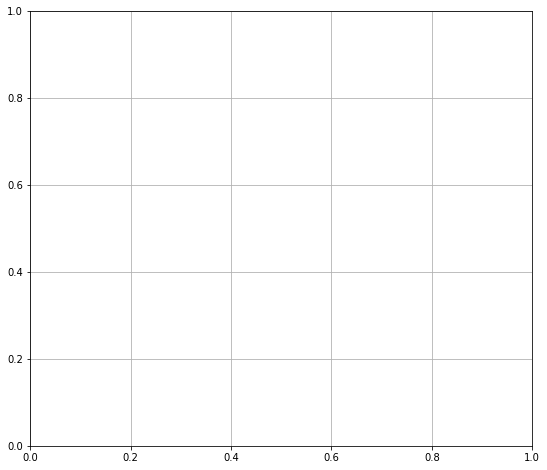

In [62]:
#Plot

#Will not work until necessary code is determined and set up.

fig = plt.figure(figsize=(9.0,8.0))                #size of the plot
ax = plt.axes()
ax.grid(True)
ax.yaxis.grid(True,which='minor',linestyle='--')

plt.plot(r0, vtotalv(r0), linestyle='solid', label='Velocity')          

fig.suptitle('Total Rotation Curve NGC5533', fontsize=18)
ax.set(title='NGC 5533')              #labeling axes
ax.set_xlim(0,10)
ax.set_xlabel('r (kpc)', fontsize=14)
ax.set_ylabel('v (km/s)', fontsize=14)
ax.xaxis.set_tick_params(labelsize=14)
ax.yaxis.set_tick_params(labelsize=14);

plt.savefig('Outputs/total.png')